# Семинар №4 

In [ ]:
import numpy as np
import cv2 
import skimage.exposure
import skimage.io
import skimage.feature
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# вспомогательная функция
def plot_transform_result(src_image, transform_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение и его преобразование.
    
    :param src_image: np.ndarray: исходное изображение
    :param transform_image: np.ndarray: преобразованное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 2, figsize=(6.4*2, 4.8*2), constrained_layout=True)
    ax1, ax2 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    ax2.set_title('Результат преобразования')
    ax2.imshow(transform_image, cmap=cmap)
    ax2.set_xticks([]), ax2.set_yticks([])
    plt.show()

In [ ]:
# вспомогательная функция
def plot_one_image(src_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение.
    
    :param src_image: np.ndarray: исходное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 1, figsize=(6.4*2, 4.8*2), constrained_layout=True)
    ax1 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    plt.show()

# Гистограммы ориентированных градиентов. Histogram of Oriented Gradients (HOG)
 
<img src="img/hog.png" alt="Drawing" style="width: 600px;"/> 

### Алгоритм подсчета HOG для картинки

1) Делим изображение на "клетки" размером 8 х 8 (предпочтительнее) и в каждой клетке подсчитываем **магнитуду** и **направление** градиентов, для этого:
    - считаем Gx (градиент вдоль оси ОХ) и Gy (градиент вдоль оси ОУ) в окне
    - направление градиента считается по формуле 
    
    <img src="img/ori.png" alt="Drawing" style="width: 150px;"/> 
    
    - магнитуда считается по формуле


    <img src="img/mag.png" alt="Drawing" style="width: 150px;"/> 
    
2) Создаем гистограмму, где bins - это 9 промежутков в углах от 0 до 180 градусов. 0-20, 20-40, ... 160-180, а сами значения для построения это магнитуды градииентов.
Также нужно нормализовать гистограмму.

    <img src="img/hist1.png" alt="Drawing" style="width: 400px;"/> 
    
3) Теперь, если отобразить HOG, то в каждой клетке размером 8х8 мы увидим направления и магнитуды градиентов ( их всего будет 8)

P.S. Лучше изменять размер изображения так, чтобы оно могло разделиться на клетки без остатков. Иначе в оставшихся частях HOG считаться не будет
Попробуйте в следующем блоке кода менять параметр pixels_per_cell на 
- (8, 8) - классический HOG
- (100, 100) - тогда будет видно, что в каждой клетке рисуются все 8 направлений градиентов, но магнитуды у них будут различаться
- (400, 400) - тогда будет заметно, что в части, которую не получилось захватить кном размером (400, 400) не будет нарисован HOG
    

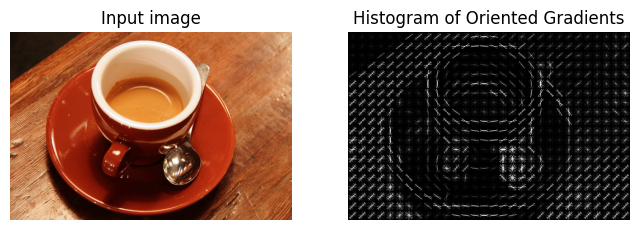

In [36]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure


image = data.coffee()

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(20, 20),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()



# Контуры на изображении

## Оператор Собеля

**Оператор Собеля** $-$ это дискретный дифференциальный оператор, вычисляющий приближение градиента яркости изображения.
Оператор вычисляет градиент яркости изображения в каждой точке. Так находится направление наибольшего увеличения яркости и величина её изменения в этом направлении. Результат показывает, насколько «резко» или «плавно» меняется яркость изображения в каждой точке, а значит, вероятность нахождения точки на грани, а также ориентацию границы.

Т.о. результатом работы оператора Собеля в точке области постоянной яркости будет нулевой вектор, а в точке, лежащей на границе областей различной яркости — вектор, пересекающий границу в направлении увеличения яркости.

Наиболее часто оператор Собеля применяется в алгоритмах выделения границ. 

Оператор Собеля основан на свёртке изображения небольшими целочисленными фильтрами в вертикальном и горизонтальном направлениях, поэтому его относительно легко вычислять. Оператор использует ядра 3x3, с которыми свёртывают исходное изображение для вычисления приближенных значений производных по горизонтали и по вертикали.


### Формализация
Пусть ${\displaystyle \mathbf {A} }$ $-$ это исходное изображение, а ${\displaystyle \mathbf {G} _{x}}$ и ${\displaystyle \mathbf {G} _{y}}$ $-$ два изображения, на которых каждая точка содержит приближённые производные по ${\displaystyle x}$ и по ${\displaystyle y}$. Они вычисляются следующим образом:

${\displaystyle \mathbf {G} _{y}={\begin{bmatrix}-1&-2&-1\\0&0&0\\+1&+2&+1\\\end{bmatrix}}*\mathbf {A} \quad {\mbox{and}}\quad \mathbf {G} _{x}={\begin{bmatrix}-1&0&+1\\-2&0&+2\\-1&0&+1\end{bmatrix}}*\mathbf {A} }$

## Контур и как его найти

**Контурный анализ** $-$ это один из важных и очень полезных методов описания, хранения, распознавания, сравнения и поиска графических образов/объектов. 

**Контур** $-$ это внешние очертания (обвод) предмета/объекта.

При проведении контурного анализа:
* полагается, что контур содержит достаточную информацию о форме объекта;
* внутренние точки объекта во внимание не принимаются. 

Вышеприведённые положения, разумеется, накладывают существенные ограничения на область применения контурного анализа, которые, в основном, связаны с проблемами выделения контура на изображениях:
* из-за одинаковой яркости с фоном объект может не иметь чёткой границы, или может быть зашумлён помехами, что приводит к невозможности выделения контура;
* перекрытие объектов или их группировка приводит к тому, что контур выделяется неправильно и не соответствует границе объекта.

Однако, переход к рассмотрению только контуров объектов позволяет уйти от пространства изображения – к пространству контуров, что существенно снижает сложность алгоритмов и вычислений. 

Т.о., контурный анализ имеет довольно слабую устойчивость к помехам, и любое пересечение или лишь частичная видимость объекта приводит либо к невозможности детектирования, либо к ложным срабатываниям, но простота и быстродействие контурного анализа, позволяют вполне успешно применять данный подход (при чётко выраженном объекте на контрастном фоне и отсутствии помех).

Итак, мы определились, что контур — это некая граница объекта, которая отделяет его от фона (других объектов). 

Во всех случаях мы получаем бинарное изображение, которое явным образом задаёт нам границы объекта. Вот эта совокупность пикселей, составляющих границу объекта и есть контур объекта.

Чтобы оперировать полученным контуром, его необходимо как-то представить (закодировать). 
Например, указывать вершины отрезков, составляющих контур.
Другой известный способ кодирования контура $-$ это **цепной код Фримена**. Этот метод будет рассмотрен чуть позже.

## Оператор Лапласа
Он вычисляет лапласиан изображения, заданного соотношением,
${\Delta src = \frac{\partial ^2{src}}{\partial x^2} + \frac{\partial ^2{src}}{\partial y^2}}$
где каждая производная находится с использованием производных Собеля. Если ksize = $3$, то для фильтрации используется следующее ядро:

$$
{K = \begin{pmatrix}
0 & \ 1 & \ 0 \\ 
1 & \ -4 & \ 1 \\ 
0 & \ 1 & \ 0 
\end{pmatrix}}$$

In [ ]:
img = cv2.imread('img/lk.jpg')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

## выделяем границы
gray_img = cv2.GaussianBlur(gray_img, ksize=(7, 7), sigmaX=1, sigmaY=1)
laplac = cv2.Laplacian(gray_img, cv2.THRESH_BINARY, scale=0.55, ksize=5)

plot_transform_result(gray_img, laplac, is_gray=True)

## Детектор границ Кенни (Canny)

### Теория
**Canny Edge Detection** $-$ популярный алгоритм обнаружения краев. Это многоступенчатый алгоритм, и мы пройдем через все этапы.

1. **Шумоподавление**

Поскольку обнаружение краев подвержено воздействию шума на изображении, первым шагом является удаление шума на изображении с помощью фильтра Гаусса $5\times5$. Мы уже видели это в предыдущих главах.

2. **Поиск градиента интенсивности изображения**

Затем сглаженное изображение фильтруется ядром Собеля (рассмотрен выше) в горизонтальном и вертикальном направлении, чтобы получить первую производную в горизонтальном направлении ($G_x$) и вертикальном направлении ($G_y$). Из этих двух изображений мы можем найти градиент края и направление для каждого пикселя следующим образом:

$${Edge(G) = \sqrt{ G_x^2 + G_y^2}}$$
$${Angle(\theta) = \tan^{-1}(\frac{G_x}{G_y})}$$

Направление градиента всегда перпендикулярно краям. Он округлен до одного из четырех углов, представляющих вертикальное, горизонтальное и два диагональных направления.

3. **Немаксимальное подавление**

После получения величины и направления градиента выполняется полное сканирование изображения для удаления любых нежелательных пикселей, которые могут не составлять края. Для этого в каждом пикселе пиксель проверяется, является ли он локальным максимумом в его окрестности в направлении градиента. Проверьте изображение ниже:

<img src="https://i.ibb.co/XZZVNmK/nms.jpg" alt="Drawing" style="width: 500px;"/> 

Точка $А$ находится на краю (в вертикальном направлении). Направление градиента нормальное к краю. Точки $B$ и $C$ находятся в градиентных направлениях. Таким образом, точка $A$ проверяется с помощью точек $B$ и $C$, чтобы увидеть, образует ли она локальный максимум. Если это так, он рассматривается для следующего этапа, в противном случае он подавляется (обнуляется).

Короче говоря, в результате вы получите бинарное изображение с «тонкими краями».

4. **Подбор порогового значения**

Эта стадия решает, какие ребра действительно являются ребрами, а какие нет. Для этого нам понадобятся два пороговых значения, **minVal** и **maxVal**. Любые ребра с градиентом интенсивности, превышающим **maxVal**, обязательно будут ребрами, а ребра ниже **minVal** не будут ребрами, поэтому отбрасываются. Те, кто лежит между этими двумя порогами, классифицируются как ребра или не ребра в зависимости от их связности. Если они связаны с точными пикселями, они считаются частью ребер. В противном случае они также отбрасываются. Смотрите изображение ниже:

<img src="https://i.ibb.co/cryRqvD/hysteresis.jpg" alt="Drawing" style="width: 500px;"/> 

Край $A$ выше **maxVal**, так что считается «верным краем». Хотя ребро $C$ меньше **maxVal**, оно связано с ребром $A$, так что это также считается допустимым ребром, и мы получаем эту полную кривую. Но ребро $B$, хотя оно выше **minVal** и находится в той же области, что и ребро $C$, не связано с каким-либо «верным краем», поэтому отбрасывается. Поэтому очень важно, чтобы мы выбрали соответственно **minVal** и **maxVal**, чтобы получить правильный результат.

На этом этапе также удаляются небольшие пиксельные шумы в предположении, что края являются длинными линиями.

Итак, что мы в итоге получаем, это сильные края изображения.

## Детектор границ Кенни в OpenCV
OpenCV помещает все вышеперечисленное в одну функцию ```cv2.Canny(image,threshold1,threshold2,apertureSize,L2gradient)```. 

* **image** $-$ это наше входное изображение
* **threshold1** $-$ minVal для процедуры гистерезиса
* **threshold2** $-$ maxVal для процедуры гистерезиса
* **apertureSize** $-$ размер ядра Собеля, используемый для поиска градиентов изображения, по умолчанию равен $3$
* **L2gradient** $-$ флаг, определяет уравнение для определения величины градиента. Если это True, он использует упомянутое выше уравнение, которое является более точным, в противном случае он использует эту функцию: Edge_Gradient($G$) = |$G_x$| + |$G_y$|. По умолчанию это False.

In [ ]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged

In [ ]:
img = cv2.imread('img/lk.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)

edges = auto_canny(blurred)

plot_transform_result(gray, edges, is_gray=True)

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)

edges = cv2.Laplacian(blurred, cv2.THRESH_BINARY, scale=0.25, ksize=7)

plot_transform_result(gray, edges, is_gray=True)

In [ ]:
edges = skimage.feature.canny(gray, sigma=1)

plot_transform_result(gray, edges, is_gray=True)

## Выделяем контуры

Полученные границы достаточно просто преобразуются в контуры. Для алгоритма Кэнни это происходит автоматически, для остальных алгоритмов требуется дополнительная бинаризация. Получить контур для бинарного алгоритма можно например алгоритмом [жука](http://wiki.technicalvision.ru/index.php/%D0%92%D1%8B%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B8_%D0%BE%D0%BF%D0%B8%D1%81%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BA%D0%BE%D0%BD%D1%82%D1%83%D1%80%D0%BE%D0%B2).

В OpenCV поиск контуров похож на поиск белого объекта на черном фоне. Помните, что объект, который нужно найти, должен быть белым, а фон должен быть черным.
Давайте посмотрим, как найти контуры двоичного изображения с помощью метода **Фридмана**:

**Цепной код Фримена (Фридмана) (Freeman Chain Code)**

Цепные коды применяются для представления границы в виде последовательности отрезков прямых линий определённой длины и направления. В основе этого представления лежит 4- или 8- связная решётка. Длина каждого отрезка определяется разрешением решётки, а направления задаются выбранным кодом.
(для представления всех направлений в 4-связной решётке достаточно 2-х бит, а для 8-связной решётки цепного кода требуется 3 бита)

<img src="https://i.ibb.co/6tyGLKS/freeman_chain_code.png" alt="Drawing" style="width: 300px;"/> 

Если честно, то у меня ни разу ни получилось применить контурный анализ в реальных задачах. Уж слишком идеальные условия требуются. То граница не найдётся, то шумов слишком много. Но, если нужно что-то распознавать в идеальных условиях $-$ то контурный анализ замечательный вариант. Очень быстро работает, красивая математика и понятная логика.

В OpenCV для поиска контуров имеется функцией findContours, которая имеет вид:

```findContours(img, hierarchy, mode, method, offset)```


1. img — должным образом подготовленная для анализа картинка. Это должно быть 8-битное изображение. Поиск контуров использует для работы монохромное изображение, так что все пиксели картинки с ненулевым цветом будут интерпретироваться как 1, а все нулевые останутся нулями.


2. mode — один из четырех режимов группировки найденных контуров:
    * CV_RETR_LIST — выдаёт все контуры без группировки;
    * CV_RETR_EXTERNAL — выдаёт только крайние внешние контуры. Например, если в кадре будет пончик, то функция вернет его внешнюю границу без дырки.
    * CV_RETR_CCOMP — группирует контуры в двухуровневую иерархию. На верхнем уровне — внешние контуры объекта. На втором уровне — контуры отверстий, если таковые имеются. Все остальные контуры попадают на верхний уровень.
    * CV_RETR_TREE — группирует контуры в многоуровневую иерархию.


3. method — один из трёх методов упаковки контуров:
    * CV_CHAIN_APPROX_NONE — упаковка отсутствует и все контуры хранятся в виде отрезков, состоящих из двух пикселей.
    * CV_CHAIN_APPROX_SIMPLE — склеивает все горизонтальные, вертикальные и диагональные контуры.
    * CV_CHAIN_APPROX_TC89_L1,CV_CHAIN_APPROX_TC89_KCOS — применяет к контурам метод упаковки (аппроксимации) Teh-Chin.


4. hierarchy — список всех найденных контуров, представленных в виде векторов; иерархия — информация о топологии контуров. Каждый элемент иерархии представляет собой сборку из четырех индексов, которая соответствует контуру[i]:
    * иерархия[i][0] — индекс следующего контура на текущем слое;
    * иерархия[i][1] — индекс предыдущего контура на текущем слое:
    * иерархия[i][2] — индекс первого контура на вложенном слое;
    * иерархия[i][3] — индекс родительского контура.


5. offset — величина смещения точек контура. Это полезно, если контуры извлекаются из ROI, а затем они должны анализироваться во всем контексте изображения.

In [ ]:
img = cv2.imread('img/RGB_cube.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

blur = cv2.medianBlur(gray_img, 3)
laplac = cv2.Laplacian(blur, cv2.THRESH_BINARY, scale=0.15, ksize=5)

contours, hierarchy = cv2.findContours(laplac, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

plot_transform_result(gray, laplac, is_gray=True)

## Как нарисовать контуры?

Для рисования контуров используется функция:

```drawContours(image, contours, contourIdx, color, thickness, lineType, hierarchy, maxLevel, offset)```

1. image — кадр, поверх которого мы будем отрисовывать контуры; 


2. contours — те самые контуры, найденные функцией findContours; 


3. contourIdx — индекс контура, который следует отобразить. 
    * -1 — если нужно отобразить все контуры; 


4. color — цвет контура; 


5. thickness — толщина линии контура; 


6. lineType — тип соединения точек вектора; 


7. hierarchy — информация об иерархии контуров; 


8. maxLevel — индекс слоя, который следует отображать. 
    * Если параметр равен 0, то будет отображен только выбранный контур. Если параметр равен 1, то отобразится выбранный контур и все его дочерние контуры. Если параметр равен 2, то отобразится выбранный контур, все его дочерние и дочерние дочерних! И так далее. 
    

9. offset — величина смещения точек контура.

Его также можно использовать для рисования любой фигуры, если у вас есть граничные точки. Его первый аргумент является исходным изображением, второй аргумент - это контуры, которые должны быть переданы в виде списка Python, третий аргумент - это индекс контуров (полезно при рисовании отдельного контура. Чтобы нарисовать все контуры, передайте -1), а остальные аргументы - это цвет, толщина и т.п.

In [ ]:
new_contours = []
for cnt in contours:
    if cnt.shape[0] > 30:
        new_contours.append(cnt)

In [ ]:
len(contours) - len(new_contours)

In [ ]:
# нарисуем все найденные контуры
img1 = gray_img.copy()
img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
cv2.drawContours(img1, new_contours, 15, (255, 0, 0), 3)

plot_one_image(img1)

In [ ]:
# нарисуем один выбранный контур
img2 = gray_img.copy()
img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
cv2.drawContours(img2, contours, 15, (255, 0, 0), 2)

plot_one_image(img2)

# Ключевые признаки контура

Пройдемся по основным методам работы с характеристиками конутра, которые доступны в OpenCV.

## Моменты
Моменты изображения помогают вам рассчитать некоторые функции, такие как центр масс объекта, площадь объекта и т. д.

Функция **cv2.moments()** предоставляет словарь всех вычисленных значений моментов.

__Центральные моменты__

$\mu _{{pq}}=\sum _{{x}}\sum _{{y}}(x-{\bar  {x}})^{p}(y-{\bar  {y}})^{q}f(x,y)$

__Масштабные инварианты__

Инварианты $η_{ij}$ относительно сдвига и масштаба могут быть построены из центральных моментов путем деления на правильно масштабированный нулевой центральный момент:

${\displaystyle \eta _{ij}={\frac {\mu _{ij}}{\mu _{00}^{\left(1+{\frac {i+j}{2}}\right)}}}\}\$, 
где i + j ≥ 2. Обратите внимание, что трансляционная инвариантность непосредственно следует только за счет использования центральных моментов.

__Вращающиеся инварианты__

Как показано в работе Ху, могут быть построены инварианты относительно перемещения, масштаба и вращения:

${\displaystyle I_{1}=\eta _{20}+\eta _{02}} I_{1}=\eta _{{20}}+\eta _{{02}}$

${\displaystyle I_{2}=(\eta _{20}-\eta _{02})^{2}+4\eta _{11}^{2}} I_{2}=(\eta _{{20}}-\eta _{{02}})^{2}+4\eta _{{11}}^{2}$

${\displaystyle I_{3}=(\eta _{30}-3\eta _{12})^{2}+(3\eta _{21}-\eta _{03})^{2}} I_{3}=(\eta _{{30}}-3\eta _{{12}})^{2}+(3\eta _{{21}}-\eta _{{03}})^{2}$

${\displaystyle I_{4}=(\eta _{30}+\eta _{12})^{2}+(\eta _{21}+\eta _{03})^{2}} I_{4}=(\eta _{{30}}+\eta _{{12}})^{2}+(\eta _{{21}}+\eta _{{03}})^{2}$

${\displaystyle I_{5}=(\eta _{30}-3\eta _{12})(\eta _{30}+\eta _{12})[(\eta _{30}+\eta _{12})^{2}-3(\eta _{21}+\eta _{03})^{2}]+(3\eta _{21}-\eta _{03})(\eta _{21}+\eta _{03})[3(\eta _{30}+\eta _{12})^{2}-(\eta _{21}+\eta _{03})^{2}]}$

${\displaystyle I_{6}=(\eta _{20}-\eta _{02})[(\eta _{30}+\eta _{12})^{2}-(\eta _{21}+\eta _{03})^{2}]+4\eta _{11}(\eta _{30}+\eta _{12})(\eta _{21}+\eta _{03})}$

${\displaystyle I_{7}=(3\eta _{21}-\eta _{03})(\eta _{30}+\eta _{12})[(\eta _{30}+\eta _{12})^{2}-3(\eta _{21}+\eta _{03})^{2}]-(\eta _{30}-3\eta _{12})(\eta _{21}+\eta _{03})[3(\eta _{30}+\eta _{12})^{2}-(\eta _{21}+\eta _{03})^{2}].}$

${\displaystyle I_{8}=\eta _{11}[(\eta _{30}+\eta _{12})^{2}-(\eta _{03}+\eta _{21})^{2}]-(\eta _{20}-\eta _{02})(\eta _{30}+\eta _{12})(\eta _{03}+\eta _{21})}$

${\displaystyle I_{8}=\eta _{11}[(\eta _{30}+\eta _{12})^{2}-(\eta _{03}+\eta _{21})^{2}]-(\eta _{20}-\eta _{02})(\eta _{30}+\eta _{12})(\eta _{03}+\eta _{21})}$

Они хорошо известны как инварианты моментов Ху.

Первый, I1, аналогичен моменту инерции вокруг центроида изображения, где интенсивности пикселей аналогичны физической плотности. Последний, I7, является косоинвариантным, что позволяет ему отличать зеркальные изображения от других идентичных изображений.

In [ ]:
img = cv2.imread('img/RGB_cube.png')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

blur = cv2.medianBlur(gray_img, 3)
laplac = cv2.Laplacian(blur, cv2.THRESH_BINARY, scale=1, ksize=5)
contours, hierarchy = cv2.findContours(laplac, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

plot_one_image(laplac)

In [ ]:
# нарисуем один выбранный контур
img2 = gray_img.copy()
img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
cv2.drawContours(img2, contours, 212, (255, 0, 0), 2)

plot_one_image(img2)

In [ ]:
len(contours)

In [ ]:
cnt = contours[212]
M = cv2.moments(cnt)
print(M)

In [ ]:
# Коэффициент асимметрии
import math
sigma_x = math.sqrt(M['m20']/M['m00'])
sigma_y = math.sqrt(M['m02']/M['m00'])

k_x = M['m30']/sigma_x**3
k_y = M['m03']/sigma_y**3

print(k_x, k_y)

Из этих моментов вы можете извлечь полезные данные, такие как площадь, центроид и т.д. Центроид определяется отношениями, ${C_x = \frac{M_{10}}{M_{00}}}$ and ${C_y = \frac{M_{01}}{M_{00}}}$.

In [ ]:
Cx = int(M['m10'] /M ['m00'])
Cy = int(M['m01'] / M['m00'])
print('Cx =', Cx, 'Cy =', Cy)

img2 = gray_img.copy()
img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
cnt = contours[212]
cv2.drawContours(img2, [cnt], 0, (255, 0, 0), 3)
plt.scatter(Cx, Cy, color='blue')

plt.grid()
plt.imshow(img2);

Чтобы рассчитать все моменты Ху есть функция ```cv2.HuMoments(moments)````

In [ ]:
hu = cv2.HuMoments(M)

print(hu)

__Пример сохранения моментов__

<img src="https://i.ibb.co/1nL7q4w/HuMoments.png" alt="Drawing" style="width: 600px;"/> 

### Расстояние между двумя фигурами с помощью matchShapes

В этом разделе мы узнаем, как использовать моменты Ху, чтобы найти расстояние между двумя фигурами. Если расстояние маленькое, формы близки по внешнему виду, а если расстояние большое, то фигуры находятся дальше друг от друга по внешнему виду.

OpenCV предоставляет простую в использовании служебную функцию matchShapes, которая берет два изображения (или контура) и находит расстояние между ними с помощью Hu Moments. Таким образом, вам не нужно явно вычислять моменты Ху. Просто оцифруйте изображения и используйте matchShapes.

Использование показано ниже.

In [ ]:
img = cv2.imread('img/lk.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
rows, cols = img.shape

M1 = cv2.getRotationMatrix2D((cols/2, rows/2), 25, scale=1.0)
M2 = cv2.getRotationMatrix2D((300, 700), -15, scale=0.75)

dst1 = cv2.warpAffine(img.copy(), M1, (cols, rows))
dst2 = cv2.warpAffine(img.copy(), M2, (cols, rows))

plot_transform_result(img, dst1, is_gray=True)
plot_transform_result(img, dst2, is_gray=True)

In [ ]:
d1 = cv2.matchShapes(dst1, dst2, cv2.CONTOURS_MATCH_I1,0)
d2 = cv2.matchShapes(dst1, dst2, cv2.CONTOURS_MATCH_I2,0)
d3 = cv2.matchShapes(dst1, dst2, cv2.CONTOURS_MATCH_I3,0)

print(f'Расстояние по I1: {d1:.5f}\n'
      f'Расстояние по I2: {d2:.5f}\n'
      f'Расстояние по I3: {d3:.5f}')

Обратите внимание, что есть три вида расстояний, которые можно использовать с помощью третьего параметра (CONTOURS_MATCH_I1, CONTOURS_MATCH_I2 или CONTOURS_MATCH_I3).

Два изображения (im1 и im2) похожи, если указанные выше расстояния малы. Вы можете использовать любую меру расстояния. Они обычно дают похожие результаты.

Давайте посмотрим, как определяются эти три расстояния.

Пусть $ D (A, B) $ - расстояние между формами $ A $ и $ B $, а $ H ^ A_i $ и $ H ^ B_i $ - логарифмические преобразования $ i ^ {th} $ Ху Моментов для фигур $ A $ и $ B $. Расстояния, соответствующие трем случаям, определяются как

CONTOURS_MATCH_I1
   \begin{align*} D(A, B) = \sum^{6}_{i=0} \left | \frac{1}{H^B_i} - \frac{1}{H^A_i} \right |  \end{align*}

CONTOURS_MATCH_I2
   \begin{align*} D(A, B) = \sum^{6}_{i=0} \left | H^B_i - H^A_i \right |  \end{align*}

CONTOURS_MATCH_I3
   \begin{align*} D(A, B) = \sum^{6}_{i=0} \frac{\left | H^A_i - H^B_i \right |}{\left | H^A_i \right |}  \end{align*}

### Custom distance measure
Если вы хотите определить собственную меру расстояния между двумя фигурами, вы можете легко это сделать. Например, вы можете использовать евклидово расстояние между моментами Ху, заданными

  \begin{align*} D(A, B) = \sqrt { \sum^{6}_{i=0} \left ( H^B_i - H^A_i \right )^2 } \end{align*}

Сначала вы вычисляете трансформированные в журнал моменты Ху, как упомянуто в предыдущем разделе, а затем сами вычисляете расстояние вместо использования matchShapes.

## Контурная зона
Площадь контура задается функцией **cv2.contourArea()** или из моментов, **M['m00']**.

In [ ]:
area = cv2.contourArea(cnt)
print(area)

## Периметр контура
Это также называется длиной дуги. Это можно узнать с помощью функции **cv2.arcLength()**. Второй аргумент указывает, является ли фигура замкнутым контуром (если передан True) или просто кривой.

In [ ]:
perimeter = cv2.arcLength(cnt, True)
print(round(perimeter, 3))

## Контурное приближение
Он приближает форму контура к другой форме с меньшим количеством вершин в зависимости от заданной нами точности. Это реализация алгоритма Дугласа-Пекера. Проверьте страницу википедии на алгоритм и демонстрацию.

Чтобы понять это, предположим, что вы пытаетесь найти квадрат на изображении, но из-за некоторых проблем на изображении вы получили не идеальный квадрат, а "плохую форму" (как показано на первом изображении ниже). Теперь вы можете использовать эту функцию для аппроксимации формы. В этом случае второй аргумент называется эпсилон, который является максимальным расстоянием от контура до приближенного контура. Это параметр точности. Для правильного вывода необходим мудрый выбор эпсилона.

<img src="https://i.ibb.co/jHvc2HS/approx.jpg" alt="Drawing" style="width: 600px;"/> 

Выше, на втором изображении, зеленая линия показывает приблизительную кривую для эпсилона = $10$% длины дуги. Третье изображение показывает то же самое для эпсилона = $1$% длины дуги. Третий аргумент указывает, является ли кривая замкнутой или нет.

In [ ]:
epsilon = 0.1 * cv2.arcLength(cnt,True)
approx = cv2.approxPolyDP(cnt, epsilon, True)

img2 = gray_img.copy()
img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
cv2.drawContours(img2, [approx], 0, (255, 0, 0), 3)

plot_one_image(img2)

## Выпуклость контура
Выпуклая оболочка будет похожа на контурную аппроксимацию, но это не так (оба могут давать одинаковые результаты в некоторых случаях). Здесь функция **cv2.convexHull()** проверяет кривую на наличие дефектов выпуклости и исправляет ее. Вообще говоря, выпуклые кривые $-$ это кривые, которые всегда выпуклые или, по крайней мере, плоские. И если он выпуклый внутри, это называется дефектами выпуклости. Например, проверьте изображение ниже. Красная линия показывает выпуклый корпус руки. Двусторонние стрелки показывают дефекты выпуклости, которые представляют собой локальные максимальные отклонения корпуса от контуров.
<img src="https://i.ibb.co/Z2nPDCM/convexitydefects.jpg" alt="Drawing" style="width: 300px;"/> 
**hull = cv2.convexHull(points, clockwise, returnPoints)**

* **points** $-$ точки контура.

* **clockwise** $-$ флаг ориентации. Если это правда, выходной выпуклый корпус ориентирован по часовой стрелке. В противном случае он ориентирован против часовой стрелки.

* **returnPoints** $-$ по умолчанию True. Затем он возвращает координаты точек корпуса. Если False, он возвращает индексы точек контура, соответствующие точкам корпуса.

In [ ]:
hull = cv2.convexHull(cnt)
hull_id = cv2.convexHull(cnt, returnPoints=False)

plot_one_image(img2)

Но если вы хотите найти дефекты выпуклости, вам нужно передать returnPoints = False.

### Проверка выпуклости
Есть функция, чтобы проверить, является ли кривая выпуклой или нет, **cv2.isContourConvex()**. Это просто возвращает True или False

Подумайте, как это можно сделать без этой функции?

In [ ]:
k = cv2.isContourConvex(cnt)
print(k)

## Ограничивающий прямоугольник


### Прямой ограничивающий прямоугольник
Это прямой прямоугольник, он не учитывает вращение объекта. Таким образом, площадь ограничивающего прямоугольника не будет минимальной. Он находится функцией **cv2.boundingRect()**.

Пусть $(x,y)$ $-$ верхняя левая координата прямоугольника, а $(w,h)$ $-$ его ширина и высота.

In [ ]:
x, y, w, h = cv2.boundingRect(cnt)
cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

img2 = gray_img.copy()
img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)

x, y, w, h = cv2.boundingRect(cnt)
cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 255, 0), 2)

plot_one_image(img2)

## Повернутый прямоугольник
Здесь ограничивающий прямоугольник рисуется с минимальной площадью, поэтому он учитывает и вращение. Используемая функция $-$ **cv2.minAreaRect()**. Он возвращает структуру **Box2D**, которая содержит следующие детали $-$ (центр $(x, y)$, (ширина, высота), угол поворота). Но чтобы нарисовать этот прямоугольник, нам нужно $4$ угла прямоугольника. Получается функцией **cv2.boxPoints()**.

In [ ]:
img2 = gray_img.copy()
img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)


rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
cv2.drawContours(img2, [box], 0, (0, 0, 255), 2)

plot_one_image(img2)

## Подгонка линии
Точно так же мы можем подогнать линию к набору точек. Ниже изображение содержит набор белых точек. Мы можем приблизить к нему прямую линию.

In [ ]:
img2 = gray_img.copy()
img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)

rows, cols = img.shape[:2]
vx, vy, x, y = cv2.fitLine(cnt, cv2.DIST_L2, 0, 0.01, 0.01)
lefty = int((-x * vy/ vx) + y)
righty = int(((cols - x) * vy / vx) + y)
cv2.line(img2, (cols-1, righty), (0, lefty), (0, 255, 0), 2)

x, y, w, h = cv2.boundingRect(cnt)
cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 255, 0), 2)

plot_one_image(img2)

## Свойства контура

### Соотношение сторон
Это отношение ширины к высоте ограничивающего прямоугольника объекта.

${AspectRatio = \frac{Width}{Height}}$

In [ ]:
x, y, w, h = cv2.boundingRect(cnt)
aspect_ratio = float(w) / h

print(aspect_ratio)

### Степень
Степень $-$ это отношение площади контура к площади ограничивающего прямоугольника.

${Extent=\frac{Object\ Area}{Bounding\ Rectangle\ Area}}$

In [ ]:
area = cv2.contourArea(cnt)
x, y, w, h = cv2.boundingRect(cnt)
rect_area = w * h
extent = float(area) / rect_area

print(extent)

### Solidity

Solidity $-$ это отношение площади контура к его площади выпуклой оболочки.

$Solidity = \frac{Contour \ Area}{Convex \ Hull \ Area}$


In [ ]:
area = cv2.contourArea(cnt)
hull = cv2.convexHull(cnt)
hull_area = cv2.contourArea(hull)
solidity = float(area) / hull_area

print(solidity)

### Эквивалентный диаметр

Эквивалентный диаметр $-$ это диаметр круга, площадь которого равна площади контура.

$Equivalent \ Diameter = \sqrt{\frac{4 \cdot \ Contour \ Area}{\pi}}$

In [ ]:
area = cv2.contourArea(cnt)
equi_diameter = np.sqrt(4 * area / np.pi)

### Ориентация
Ориентация $-$ это угол, под которым направлен объект. Следующий метод также дает длины **Major Axis** и **Minor Axis**.


In [ ]:
(x, y), (MA, ma), angle = cv2.fitEllipse(cnt)

print(x, y, MA, ma, angle)

### Маска и пиксельные точки
В некоторых случаях нам могут понадобиться все точки, которые составляют этот объект. Это можно сделать следующим образом:


In [ ]:
mask = np.zeros(gray_img.shape, np.uint8)
cv2.drawContours(mask, [cnt], 0, 255, -1)
pixelpoints = np.transpose(np.nonzero(mask))
print(f'Numpy shape: {pixelpoints.shape}')

pixelpoints = cv2.findNonZero(mask)
print(f'CV2 shape: {pixelpoints.shape}')

Здесь два метода, один из которых использует функции Numpy, а другой $-$ функцию OpenCV (последняя закомментированная строка), дают то же самое. Результаты тоже такие же, но с небольшой разницей. Numpy дает координаты в формате **(строка, столбец)**, а OpenCV - в формате **(x, y)**. Так что в основном ответы будут взаимозаменяемы. Обратите внимание, что row = x и column = y.

### Максимальное значение, минимальное значение и их местоположение
Мы можем найти эти параметры, используя изображение маски.

In [ ]:
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(gray_img, mask = mask)

print(min_val, max_val, min_loc, max_loc)

### Средний цвет или средняя интенсивность
Здесь мы можем найти средний цвет объекта. Или это может быть средняя интенсивность объекта в режиме градаций серого. Мы снова используем ту же маску, чтобы сделать это.


In [ ]:
mean_val = cv2.mean(gray_img, mask = mask)

print(mean_val)

### Экстремальные точки
Экстремальные точки означают самые верхние, самые нижние, самые правые и самые левые точки объекта.


In [ ]:
leftmost = tuple(cnt[cnt[:, :, 0].argmin()][0])
rightmost = tuple(cnt[cnt[:, :, 0].argmax()][0])
topmost = tuple(cnt[cnt[:, :, 1].argmin()][0])
bottommost = tuple(cnt[cnt[:, :, 1].argmax()][0])

In [ ]:
print(leftmost, rightmost,'\n', topmost, bottommost)

plt.imshow(img, cmap='gray')
plt.scatter(leftmost[0], leftmost[1])
plt.scatter(rightmost[0], rightmost[1])
plt.scatter(topmost[0], topmost[1])
plt.scatter(bottommost[0], bottommost[1]);

# Практика - совместить 2 изображения (Image registration)

Задача состоит в том, чтобы совместить друг с другом (преобразовать пиксель в пиксель) 2 изображения в оптическом и радиодиапазонах.

Исходные данные доступны по [ссылке](https://disk.yandex.ru/d/AXvmkQRWrdStsQ)

In [ ]:
# Ваш код